In [1]:
import DataGenerator as dg
import Globals
import HelperFunctions as helpers
import HeatmapClass

import numpy as np
import matplotlib.pyplot as plt
import random
import json
import os

Using TensorFlow backend.
In C:\Users\yjenn\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\yjenn\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\yjenn\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


Image format (2848, 4288, 3).


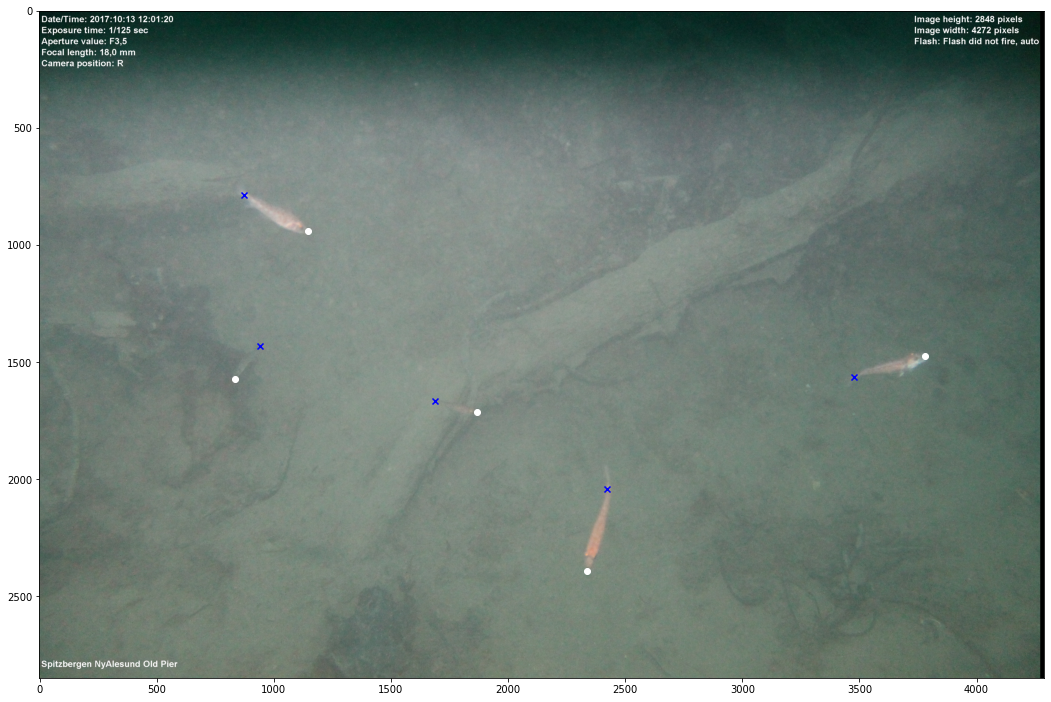

In [2]:
# set plt parameters
plt.rcParams['figure.figsize'] = 18, 27

# load annotation files
path = "../data/labels/training_labels_animals.json"
label_root = ""

with open(os.path.join(label_root, path) , 'r') as f:
    train_labels_animals = json.load(f)
    
path = "../data/labels/test_labels.json"
with open(os.path.join(label_root, path), 'r') as f:
    test_labels = json.load(f)
    
path = "../data/labels/training_labels_no_animals.json"
with open(os.path.join(label_root, path), 'r') as f:
    train_labels_no_animals = json.load(f)

# image path
#data_root = "G:/Universität/UniBremen/Semester4/Data/maritime_dataset/"#training_data_animals/"
data_root = "../data/maritime_dataset/"

imageShape = helpers.shapeOfFilename(os.path.join(data_root,"training_data_animals/0.jpg"))
print(f"Image format {imageShape}.")

# show first training image with annotations (all animal groups)
helpers.showImageWithAnnotation(train_labels_animals[0])

# check if interpolate works
#helpers.showInterpolate()

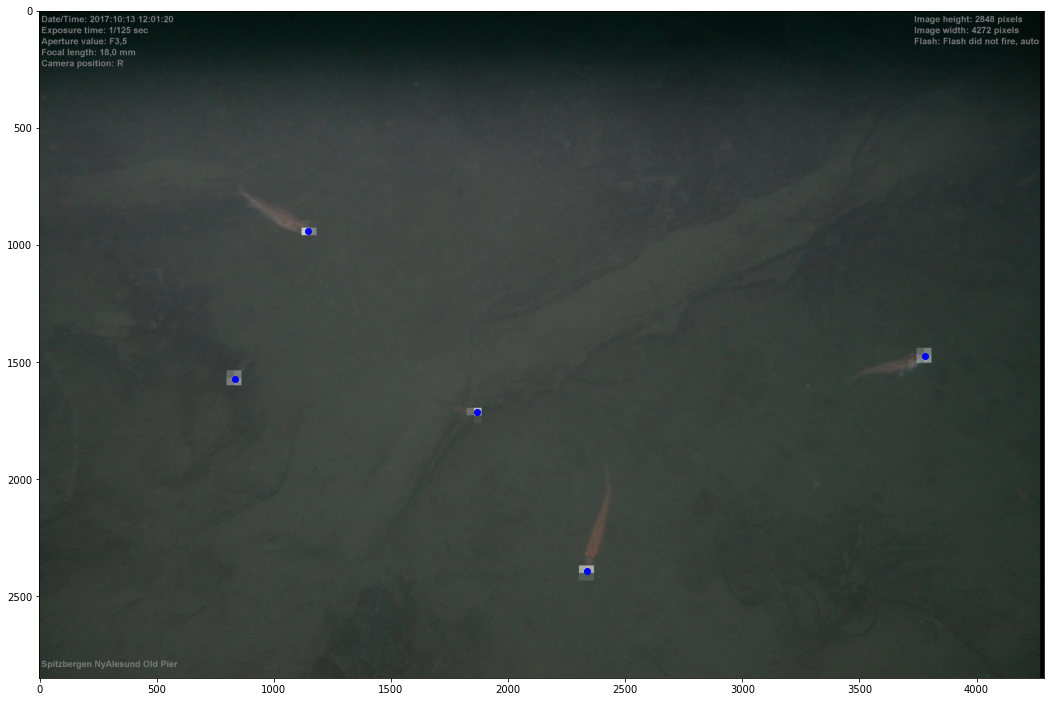

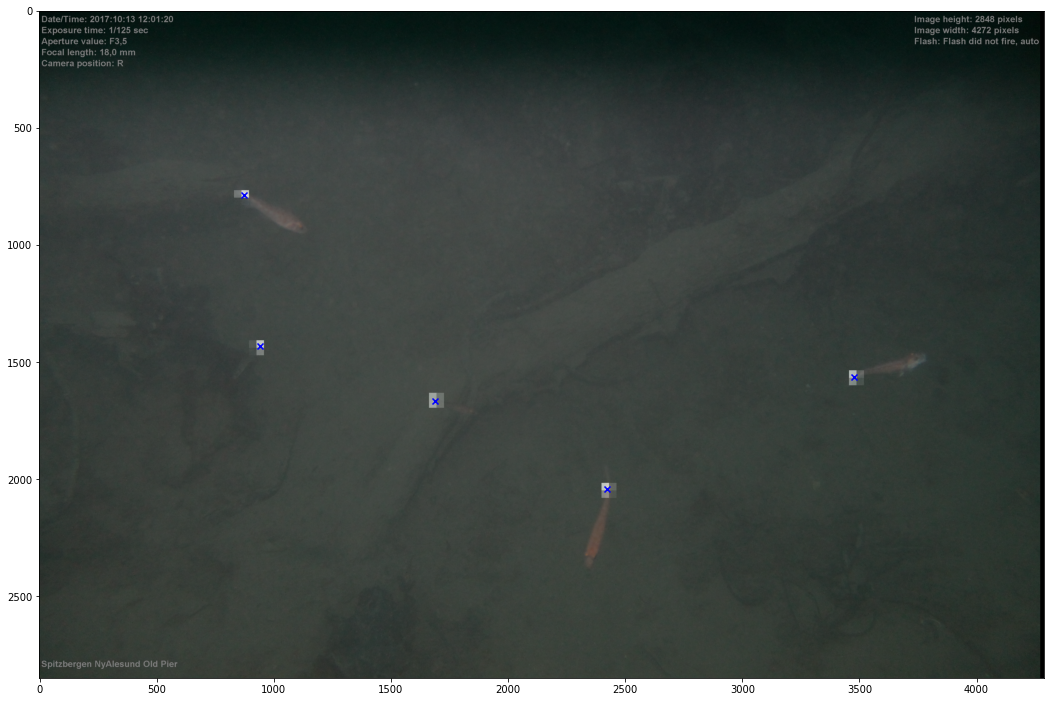

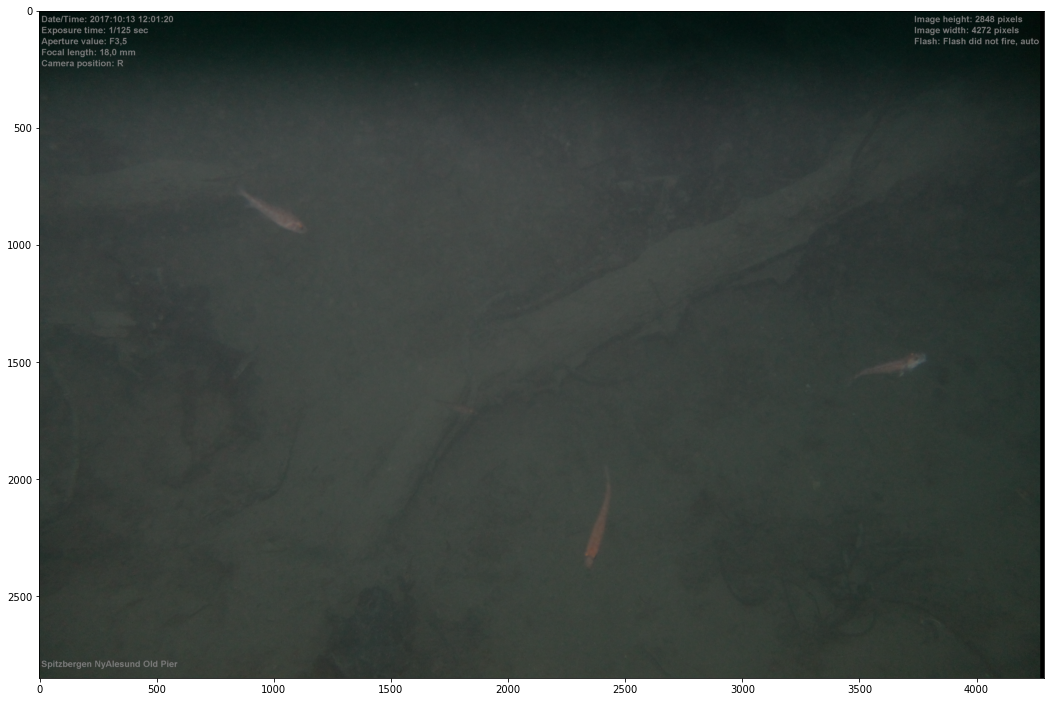

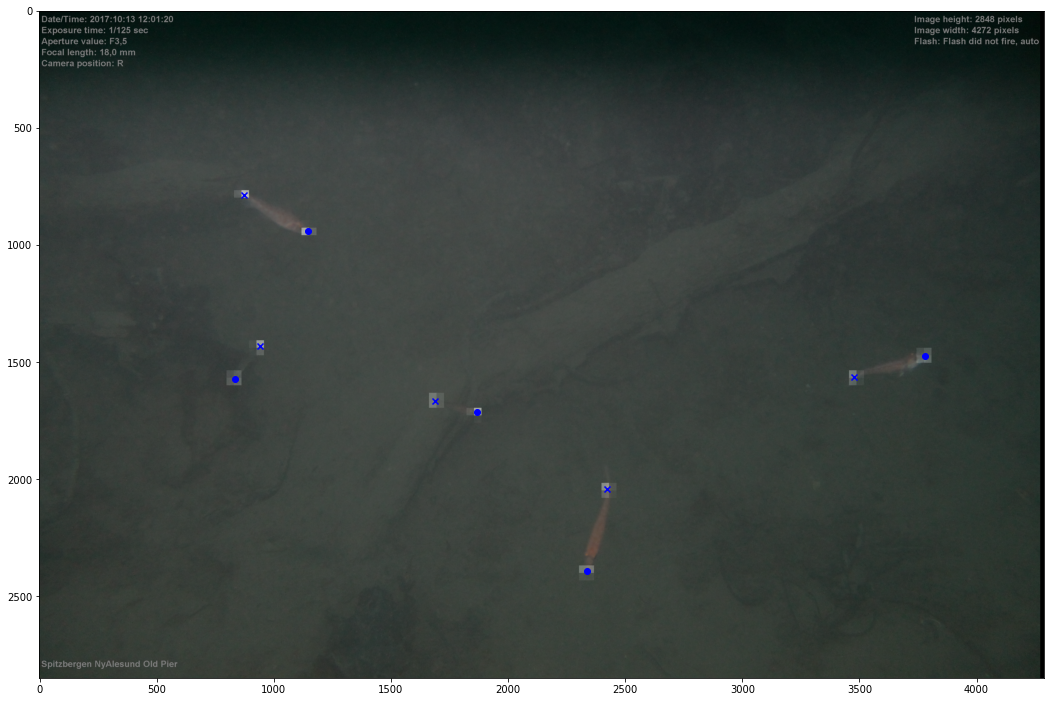

In [3]:
# test low resolution heatmap
n = 0
hm_L = HeatmapClass.Heatmap(train_labels_animals[n], group=1, bodyPart='front', resolution='low') 
hm_L.showImageWithHeatmap()
hm_L.showImageWithHeatmap(filename=None, group=1, bodyPart="back")
hm_L.showImageWithHeatmap(filename=None, group=2, bodyPart="back")
hm_L.showImageWithHeatmap(filename=None, group=1, bodyPart="both")

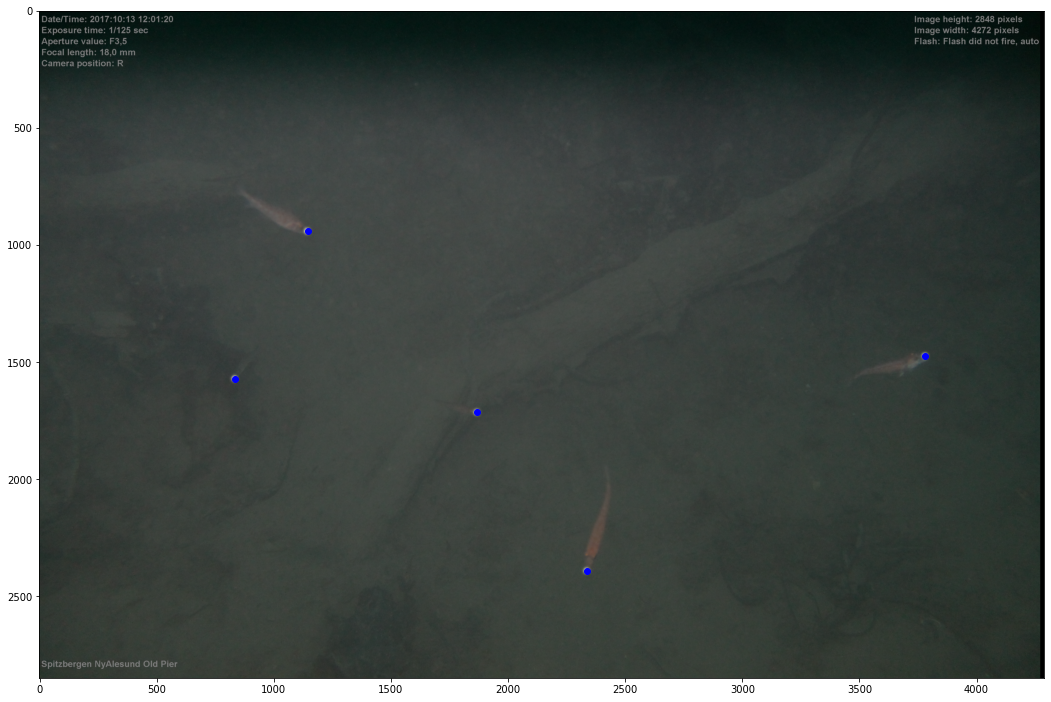

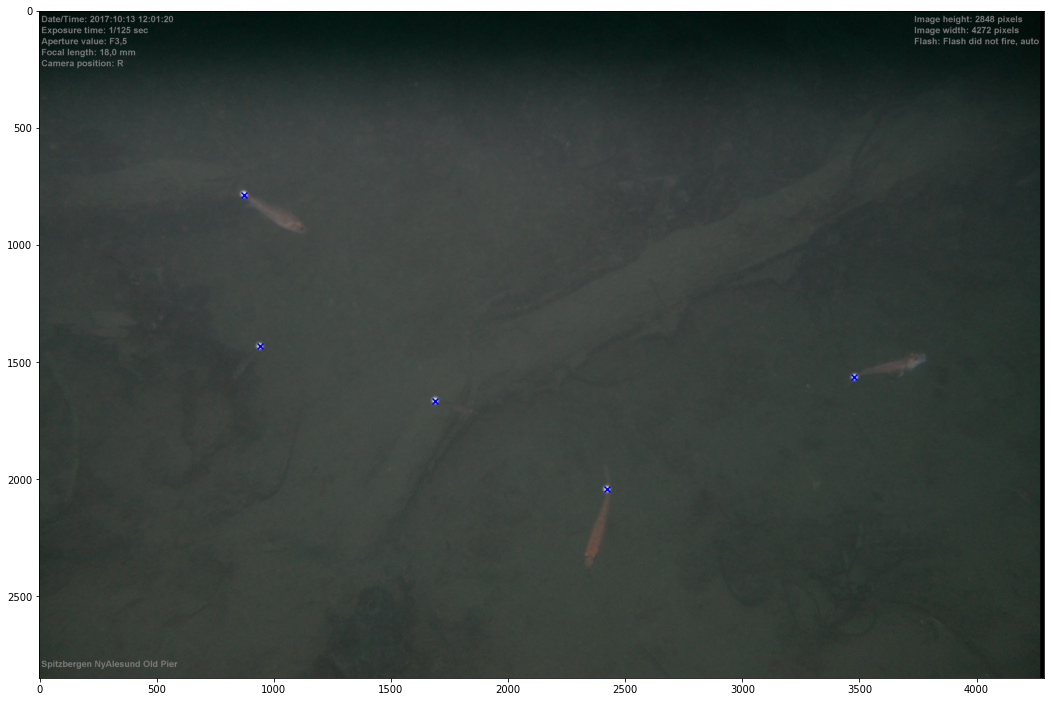

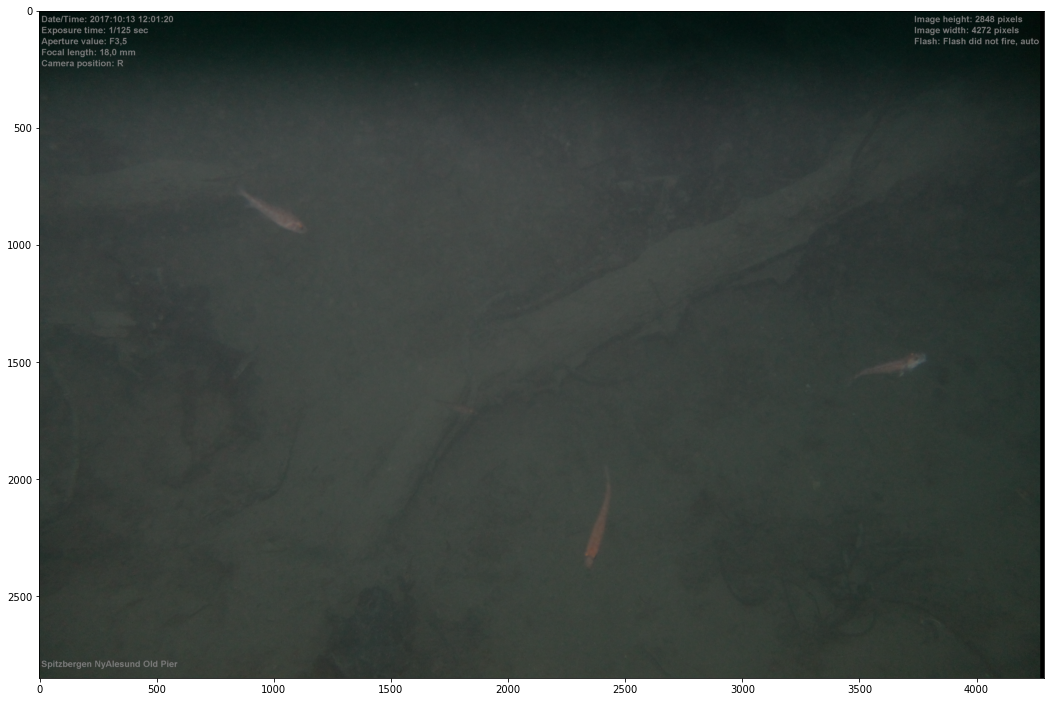

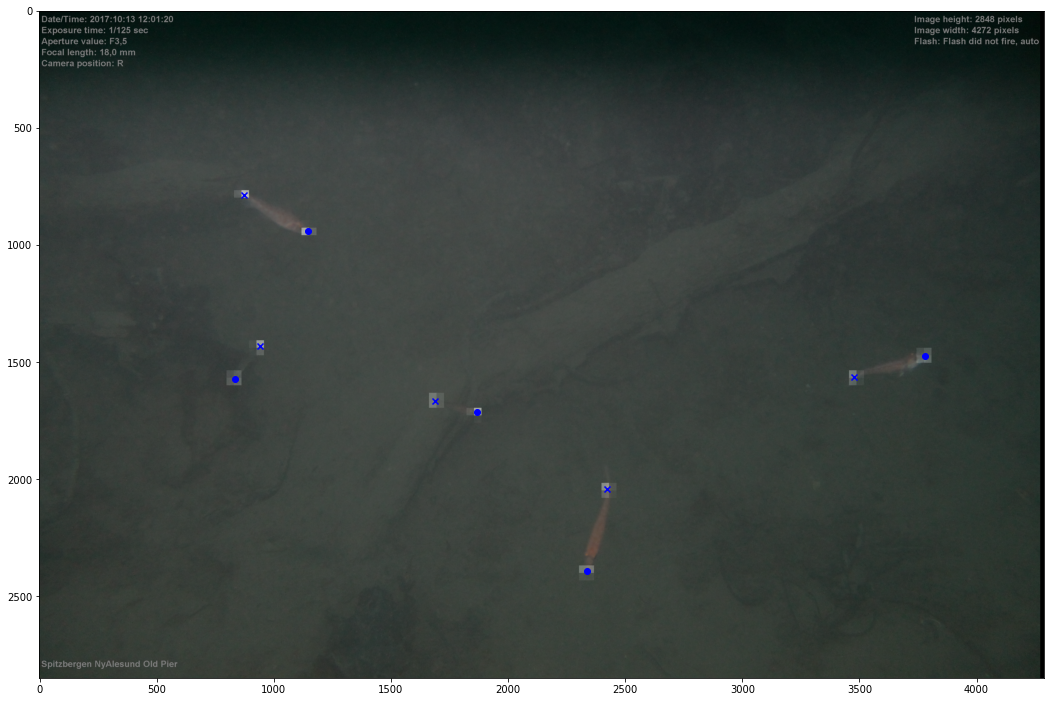

In [4]:
# test high resolution heatmap
n = 0
hm_H = HeatmapClass.Heatmap(train_labels_animals[n], group=1, bodyPart='front', resolution='high') 
hm_H.showImageWithHeatmap()
hm_H.showImageWithHeatmap(filename=None, group=1, bodyPart="back")
hm_H.showImageWithHeatmap(filename=None, group=2, bodyPart="back")
hm_H.showImageWithHeatmap(filename=None, group=1, bodyPart="both")

In [ ]:
# test data generators
trainGenL = dg.DataGenerator (train_labels_animals, prepareEntry=dg.prepareEntryLowResHeatmap)
testGenL = dg.DataGenerator (test_labels, prepareEntry=dg.prepareEntryLowResHeatmap)
dg.showEntryOfGenerator (trainGenL,0)

trainGenH = dg.DataGenerator (train_labels_animals, prepareEntry=dg.prepareEntryHighResHeatmap)
testGenH = dg.DataGenerator (test_labels, prepareEntry=dg.prepareEntryHighResHeatmap)
dg.showEntryOfGenerator (trainGenH,0)

In [ ]:
# Now construct the low-res net and store it into the variable model
# Loading of MobileNet.V2 will give a warning "`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default."
# That's correct.
# Proceed as described in abv-uebung-6.pdf and discuss the architecture.
# Inspect the architecture with model.summary() to make sure, that the number of trainable weights
# is compatible to the amount of data we have.
#
# For reference you can access the MobileNet.V2 source code at
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py

def ourBlock (x, basename, channels=NUM_GROUPS*2):
    """Our own block of computation layers used several times in the network. It is similar to
    the block used in MobileNet.V2 but simplified. x is the layer to attach the block to,
    basename the name of this block, which will be extended by layer names. channel is the
    number of channels in the output (internally a multiple of that). The final layer is returned."""
    # First reduce to the defined no of channels to avoid having too many weights
    x = layers.Conv2D (channels, 1, padding='same', name = basename+"_bottleneck_conv")(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_bottleneck_BN')(x)
    x = layers.ReLU(6., name=basename+'_bottleneck_relu')(x)

    x = layers.Conv2D (4*channels, 1, padding='same', name = basename+"_conv")(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_BN')(x)
    x = layers.ReLU(6., name=basename+'_relu')(x)

    x = layers.DepthwiseConv2D(kernel_size=3, activation=None, use_bias=False, padding='same', name=basename+'-DW')(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_DW_BN')(x)
    x = layers.ReLU(6., name=basename+'_DW_relu')(x)
    x = layers.Conv2D (channels, 1, padding='same', name = basename+"_project")(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_project_BN')(x)
    
    return x

alpha = 1.0
input = keras.layers.Input(shape=imageShape)
backbone = keras.applications.mobilenet_v2.MobileNetV2(alpha=alpha, input_tensor=input, include_top=False, weights='imagenet', pooling=None)
for l in backbone.layers:
    l.trainable = False
# We attach to the layer with 320 channels because with a 1280 channel input this conv would have too many weights
x = backbone.get_layer("block_16_project_BN").output

# Computational block á la MobileNet.V2
x = ourBlock (x, "block_17")
   
# Final output layer with sigmoid, because heatmap is within 0..1
x = layers.Conv2D (1, 1, padding='same', activation='sigmoid', name = "block_18_conv_output")(x)

modelL = keras.Model(inputs=input, outputs=x)
modelL.compile(loss='mse', optimizer='adam', metrics=['mae'])
modelL.summary()

In [ ]:
# Train the low-res-net
#model.load_weights ("strawberry-L.h5"), #load a previous checkpoint
for ctr in range(10):
    modelL.fit_generator(generator=trainGenL, epochs=10, validation_data=testGenL)
    modelL.save_weights(f"fish-L-{ctr}.h5") # saves weights (e.g. a checkpoint) locally
  
    #files.download('fish-L.h5') # download weights from e.g. google-colab to local machine

In [ ]:
# Use this to visualize results
# It shows the input image (background), the predicted heatmap (white "fog" in foreground)
# and the ground-truth (blue crosses)
testIdx = random.randint(0,len(testGenL))
testBatch = testGenL[testIdx]
gtBatch = testGenL.get_ground_truth (testIdx)
yHats = modelL.predict (testBatch[0])
for i in range(0,len(yHats)):
    showImageWithHeatmap (testBatch[0][i], yHats[i], gtBatch[i], filename=f"result-L-{i}.png") 